## Loading the data

In this step I load only the modelling data which is the cleaned dataset without the demo set so that makes it 7431 audio recordings in total.

In [1]:
import pandas as pd

df = pd.read_csv("modelling_metadata.csv")
df.head()
df.shape

(7431, 10)

## Imports and configuration

In [2]:
import os
import numpy as np

# Audio settings
SAMPLE_RATE = 16000
DURATION_SEC = 3.0
TARGET_SAMPLES = int(SAMPLE_RATE * DURATION_SEC)

# Spectrogram settings
N_FFT = 1024
HOP_LENGTH = 256
N_MELS = 128

# Expected time frames
TARGET_FRAMES = 1 + (TARGET_SAMPLES // HOP_LENGTH)

# Output folders
OUT_NPY_DIR = "mel_npy"
OUT_PNG_DIR = "mel_png"
os.makedirs(OUT_NPY_DIR, exist_ok=True)
os.makedirs(OUT_PNG_DIR, exist_ok=True)

In this step, I define the audio and spectrogram configuration used to convert speech into fixed-size log-mel spectrograms for a CNN + BiLSTM model. I resample all audio to 16 kHz and trim or pad them to a duration of 3 seconds so that every input has the same length. I compute log-mel spectrograms using 128 mel bands and a fixed hop length, which ensures a consistent time dimension required by the BiLSTM. I also create output directories for saving spectrograms as .npy files for training and .png files for visualization, ensuring a clean and reproducible data preparation pipeline.

## Loading and normalizing audio length

In [3]:
import librosa

def load_and_fix_length(path, sample_rate=SAMPLE_RATE, target_samples=TARGET_SAMPLES):
    y, sr = librosa.load(path, sr=None)

    # ensure mono audio
    if y.ndim > 1:
        y = np.mean(y, axis=0)

    # resampling only if needed
    if sr != sample_rate:
        y = librosa.resample(y, orig_sr=sr, target_sr=sample_rate)

    # padding or trimming to fixed length
    if len(y) < target_samples:
        y = np.pad(y, (0, target_samples - len(y)), mode="constant")
    else:
        y = y[:target_samples]

    return y


I use this function to load each audio file, convert it to mono if necessary, resample it to a fixed sample rate, and pad or trim it to a fixed duration. By enforcing a consistent waveform length, I ensure that all generated log-mel spectrograms have the same shape and are compatible with the CNN + BiLSTM model.

## Why is fixed-length audio required?
Neural networks require inputs of consistent shape. By trimming or padding each audio clip to a fixed duration, I ensure that all resulting mel spectrograms have the same time dimension, which simplifies batching and allows the BiLSTM to process temporal information without variable-length handling.

## Why stereo audio is converted to mono?
Stereo audio is converted to mono to ensure consistent input shape and because spatial information is not relevant for speech emotion recognition. Emotional cues are primarily encoded in pitch, energy and timing rather than channel differences.

## Converting waveform into log-Mel spectrogram

In [4]:
def wav_to_logmel(y, sample_rate=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS):
    S = librosa.feature.melspectrogram(
        y=y,
        sr=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        power=2.0
    )

    S_db = librosa.power_to_db(S, ref=np.max)

    # per-sample standardization
    S_norm = (S_db - S_db.mean()) / (S_db.std() + 1e-6)

    # output shape for PyTorch CNN: (1, n_mels, time)
    return S_norm[np.newaxis, :, :].astype(np.float32)


I use this function to convert a fixed-length audio signal into a log-mel spectrogram that is suitable for CNN + BiLSTM training. By applying log scaling and normalization and returning the spectrogram in a channel-first format, I ensure that all inputs are numerically stable, consistent in shape and directly compatible with PyTorch models.

**The steps taken:**

Take the raw audio waveform as input

Split the audio into short overlapping frames

Transform each frame into the frequency domain

Map frequencies onto the mel scale

Compute power (energy) for each mel band

Convert power values to decibels (log scaling)

Normalize the spectrogram per sample

Add a channel dimension for CNN input

Convert the output to float32 for PyTorch

## Why log scaling is applied?
Neural networks require inputs of consistent shape. By trimming or padding each audio clip to a fixed duration, I ensure that all resulting mel spectrograms have the same time dimension, which simplifies batching and allows the BiLSTM to process temporal information without variable-length handling.

## Saving a PNG preview image

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

def save_logmel_png(mel_img, out_path):
    # mel_img shape: (1, n_mels, time)
    S_img = np.squeeze(mel_img, axis=0)

    plt.figure(figsize=(4, 4))
    librosa.display.specshow(S_img)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.savefig(out_path, dpi=150, bbox_inches="tight", pad_inches=0)
    plt.close()


I use this function to save a log-mel spectrogram as a clean PNG image for visualization and inspection. By removing the channel dimension and disabling all axes and padding, I ensure that the saved image contains only the spectrogram content, while keeping the NPY files as the primary input for CNN + BiLSTM training.

## Converting and saving all files

In [6]:
max_files = None
SAVE_PNG = True
LOG_EVERY = 500           # progress printing frequency

rows = df if max_files is None else df.head(max_files)

for i, row in enumerate(rows.itertuples(index=False), start=1):
    wav_path = row.file_path
    file_name = os.path.splitext(os.path.basename(wav_path))[0]

    try:
        # loading audio and enforcing fixed length
        y = load_and_fix_length(wav_path)

        # converting to log-mel in the agreed format (1, n_mels, T)
        mel_img = wav_to_logmel(y)

        # saving NPY
        np.save(os.path.join(OUT_NPY_DIR, f"{file_name}.npy"), mel_img)

        # saving PNG
        if SAVE_PNG:
            save_logmel_png(mel_img, os.path.join(OUT_PNG_DIR, f"{file_name}.png"))

    except Exception as e:
        print(f"Skipping file due to error: {wav_path}\n  -> {e}")
        continue

    if i % LOG_EVERY == 0:
        print(f"Processed {i} files...")

print("Saved NPY spectrograms to:", OUT_NPY_DIR)
if SAVE_PNG:
    print("Saved PNG previews to:", OUT_PNG_DIR)


Processed 500 files...
Processed 1000 files...
Processed 1500 files...
Processed 2000 files...
Processed 2500 files...
Processed 3000 files...
Processed 3500 files...
Processed 4000 files...
Processed 4500 files...
Processed 5000 files...
Processed 5500 files...
Processed 6000 files...
Processed 6500 files...
Processed 7000 files...
Saved NPY spectrograms to: mel_npy
Saved PNG previews to: mel_png


I use this block to iterate through the dataset, convert each audio file into a fixed-length log-mel spectrogram and save it as a .npy file for model training, with optional PNG output for visualization. By overwriting or regenerating files in a controlled way, I ensure that all saved spectrograms follow the same preprocessing rules and are fully consistent with the CNN + BiLSTM pipeline.

## Why are NPY files used instead of images?
Spectrograms are saved as NumPy arrays rather than images to preserve exact numerical values and the true temporal structure of the signal. This format is more suitable for sequence-based models such as BiLSTMs and avoids artifacts introduced by image rendering.

## Why CNN + BiLSTM is used?
The CNN is responsible for learning local spectral patterns from the mel spectrogram, while the BiLSTM models how these patterns evolve over time. This combination allows the system to capture both short-term acoustic features and long-term emotional dynamics.

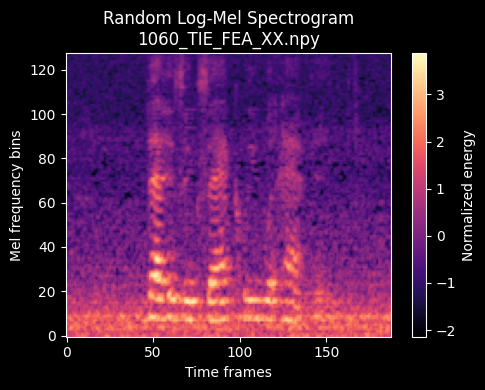

In [6]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

# Path to spectrogram folder
NPY_DIR = "mel_npy"

# Pick a random .npy file
npy_files = [f for f in os.listdir(NPY_DIR) if f.endswith(".npy")]
random_file = random.choice(npy_files)

# Load spectrogram
spec = np.load(os.path.join(NPY_DIR, random_file))

# Remove channel dimension if present
if spec.ndim == 3:
    spec = spec[0]

# Plot
plt.figure(figsize=(5, 4))
plt.imshow(spec, aspect="auto", origin="lower", cmap="magma")
plt.title(f"Random Log-Mel Spectrogram\n{random_file}")
plt.xlabel("Time frames")
plt.ylabel("Mel frequency bins")
plt.colorbar(label="Normalized energy")
plt.tight_layout()
plt.show()


## Imports

In [7]:
import os
import re
import random
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


I import standard Python and PyTorch libraries to handle file paths, numerical data, dataset splitting, and neural network training. NumPy is used to load and manipulate mel spectrograms, while PyTorch provides tensor operations, model definitions and data loading utilities required for training the CNN + BiLSTM model.

## Configurations

In [8]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# Emotion mapping
EMO_MAP = {
    "ANG": 0,
    "DIS": 1,
    "FEA": 2,
    "HAP": 3,
    "NEU": 4,
    "SAD": 5
}
NUM_CLASSES = len(EMO_MAP)

# Data location
NPY_DIR = "mel_npy"


Device: cuda


I use this block to ensure reproducibility, configure the computation device, and define all global settings required for model training. By fixing random seeds, I make experimental results repeatable, while dynamically selecting the GPU or CPU ensures efficient execution. I also define spectrogram parameters and emotion label mappings that must match the preprocessing stage, providing a consistent and well-organized configuration for training and evaluating the CNN + BiLSTM model on the CREMA-D dataset.

## Collecting all NPY files

In [9]:
npy_paths = sorted([str(p) for p in Path(NPY_DIR).glob("*.npy")])
print("Found NPY files:", len(npy_paths))


Found NPY files: 7431


## Inferring spectrogram shape

In [10]:
example = np.load(npy_paths[0])
if example.ndim == 3:
    _, N_MELS, T_FRAMES = example.shape
else:
    N_MELS, T_FRAMES = example.shape

print("Spectrogram shape:", (1, N_MELS, T_FRAMES))


Spectrogram shape: (1, 128, 188)


I load one example spectrogram to infer the number of mel bands and time frames, ensuring that the model architecture is configured to exactly match the precomputed features.

The spectrogram shape (1, 128, 188) represents a single-channel log-mel spectrogram with 128 frequency bands observed over 188 time steps, giving the model both spectral and temporal information needed for emotion recognition.

## Parsing actor ID and emotion from filename

In [11]:
def parse_actor_and_emotion(filename: str):

    # Actor ID = first number in filename
    actor_match = re.search(r"\d+", filename)
    if actor_match is None:
        raise ValueError(f"No actor ID in {filename}")
    actor_id = actor_match.group(0)

    # Emotion code
    emotion = None
    for emo in EMO_MAP:
        if f"_{emo}_" in filename or filename.startswith(f"{emo}_"):
            emotion = EMO_MAP[emo]
            break

    if emotion is None:
        raise ValueError(f"No emotion code in {filename}")

    return actor_id, emotion


## Actor-independent split

In [12]:
def actor_independent_split(paths, train_ratio=0.7, val_ratio=0.15):
    by_actor = {}

    for p in paths:
        fname = os.path.basename(p)
        actor_id, _ = parse_actor_and_emotion(fname)
        by_actor.setdefault(actor_id, []).append(p)

    actors = list(by_actor.keys())
    random.shuffle(actors)

    n = len(actors)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)

    train_actors = set(actors[:n_train])
    val_actors   = set(actors[n_train:n_train+n_val])
    test_actors  = set(actors[n_train+n_val:])

    def collect(actor_set):
        out = []
        for a in actor_set:
            out.extend(by_actor[a])
        return out

    return (
        collect(train_actors),
        collect(val_actors),
        collect(test_actors)
    )


In [13]:
train_paths, val_paths, test_paths = actor_independent_split(npy_paths)
print(len(train_paths), len(val_paths), len(test_paths))


5141 1066 1224


I use an actor-independent splitting strategy to divide the dataset into training, validation, and test sets. By grouping samples by speaker and ensuring that no actor appears in more than one split, I prevent speaker leakage and obtain a more realistic evaluation of how well the model generalizes to unseen speakers.

## PyTorch Dataset

In [14]:
class MelNPYDataset(Dataset):
    def __init__(self, paths):
        self.paths = paths

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        fname = os.path.basename(path)

        # loading spectrogram
        spec = np.load(path).astype(np.float32)
        if spec.ndim == 2:
            spec = spec[np.newaxis, :, :]

        # parsing label from filename
        _, label = parse_actor_and_emotion(fname)

        x = torch.from_numpy(spec)
        y = torch.tensor(label, dtype=torch.long)
        return x, y


I use this Dataset class to load precomputed mel spectrograms from .npy files and extract emotion labels directly from their filenames. Each sample is returned in channel-first format along with its corresponding class label, enabling efficient training without relying on external metadata

## Dataloaders

In [15]:
BATCH_SIZE = 32

train_loader = DataLoader(
    MelNPYDataset(train_paths),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    MelNPYDataset(val_paths),
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_loader = DataLoader(
    MelNPYDataset(test_paths),
    batch_size=BATCH_SIZE,
    shuffle=False
)


This block of code controls how the data is given to the model while it is training and being evaluated. It does not train the model itself. Instead, it decides how many samples are used at a time, in what order they are read, and which data is used for training, validation, and testing.

## What BATCH_SIZE = 32 means?
Setting the batch size to 32 means that the model processes 32 audio samples at once.
Instead of learning from one spectrogram at a time, the model learns from small groups of samples.

After processing one batch, the model updates its internal weights. Then it moves on to the next batch, until it has seen the entire dataset.

## What is a DataLoader?
A DataLoader is a tool that reads data from the dataset, groups samples into batches, optionally shuffles the order of samples and feeds the marches to the model during training.

In [16]:
class CNNBiLSTM(nn.Module):
    def __init__(self, lstm_hidden=128):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d((2,2)),

            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d((2,1)),

            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d((2,1))
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 1, N_MELS, T_FRAMES)
            z = self.cnn(dummy)
            C, Fp, Tp = z.shape[1], z.shape[2], z.shape[3]
            lstm_in = C * Fp

        self.lstm = nn.LSTM(
            lstm_in,
            lstm_hidden,
            batch_first=True,
            bidirectional=True
        )

        self.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(2*lstm_hidden, 128),
            nn.ReLU(),
            nn.Linear(128, NUM_CLASSES)
        )

    def forward(self, x):
        z = self.cnn(x)
        z = z.permute(0, 3, 1, 2)   # (B, T, C, F)
        z = z.flatten(2)            # (B, T, C*F)
        out, _ = self.lstm(z)
        return self.fc(out[:, -1])


In [26]:
import torch

DEVICE = torch.device("cpu")
print("Using device:", DEVICE)


Using device: cpu


In [18]:
import torch
import torch.nn as nn

model = CNNBiLSTM(lstm_hidden=128).to(DEVICE)
print(model)

# Sanity check: one batch through the model
x_batch, y_batch = next(iter(train_loader))
x_batch = x_batch.to(DEVICE)

with torch.no_grad():
    logits = model(x_batch)

print("Input batch shape:", x_batch.shape)     # (B, 1, 128, 188)
print("Logits shape:", logits.shape)           # (B, NUM_CLASSES)


CNNBiLSTM(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(2048, 128, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=6, bias=True)
  )
)
Input batch shape: torch.Size([32, 1, 128, 188])
Logits shape: torch.Size([32, 6])


In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)


In [20]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * y.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)

    return total_loss / total, correct / total


@torch.no_grad()
def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        logits = model(x)
        loss = criterion(logits, y)

        total_loss += loss.item() * y.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)

    return total_loss / total, correct / total


In [26]:
EPOCHS = 20
best_val_acc = 0.0
best_path = "best_cnn_bilstm.pt"

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
    va_loss, va_acc = eval_one_epoch(model, val_loader, criterion, DEVICE)

    print(f"Epoch {epoch:02d} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.3f} | "
          f"val loss {va_loss:.4f} acc {va_acc:.3f}")

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save(model.state_dict(), best_path)

print("Best val acc:", best_val_acc)


Epoch 01 | train loss 1.6678 acc 0.295 | val loss 1.5129 acc 0.366
Epoch 02 | train loss 1.5417 acc 0.364 | val loss 1.4627 acc 0.396
Epoch 03 | train loss 1.5101 acc 0.383 | val loss 1.4772 acc 0.382
Epoch 04 | train loss 1.4582 acc 0.405 | val loss 1.4426 acc 0.404
Epoch 05 | train loss 1.4450 acc 0.416 | val loss 1.4325 acc 0.409
Epoch 06 | train loss 1.4213 acc 0.429 | val loss 1.4425 acc 0.414
Epoch 07 | train loss 1.4205 acc 0.421 | val loss 1.3975 acc 0.420
Epoch 08 | train loss 1.3871 acc 0.442 | val loss 1.3716 acc 0.429
Epoch 09 | train loss 1.3772 acc 0.449 | val loss 1.3907 acc 0.416
Epoch 10 | train loss 1.3709 acc 0.435 | val loss 1.3614 acc 0.425
Epoch 11 | train loss 1.3567 acc 0.448 | val loss 1.3867 acc 0.449
Epoch 12 | train loss 1.3414 acc 0.455 | val loss 1.3233 acc 0.459
Epoch 13 | train loss 1.3218 acc 0.469 | val loss 1.3470 acc 0.451
Epoch 14 | train loss 1.2853 acc 0.488 | val loss 1.2995 acc 0.471
Epoch 15 | train loss 1.2656 acc 0.497 | val loss 1.2936 acc 0

In [27]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

@torch.no_grad()
def get_preds(model, loader, device):
    model.eval()
    all_y, all_p = [], []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        preds = logits.argmax(1).cpu().numpy()
        all_p.append(preds)
        all_y.append(y.numpy())
    return np.concatenate(all_y), np.concatenate(all_p)

y_true, y_pred = get_preds(model, test_loader, DEVICE)

print(classification_report(y_true, y_pred, target_names=[k for k,v in sorted(EMO_MAP.items(), key=lambda x:x[1])]))
print(confusion_matrix(y_true, y_pred))


              precision    recall  f1-score   support

         ANG       0.56      0.68      0.62       209
         DIS       0.52      0.43      0.47       209
         FEA       0.42      0.46      0.44       209
         HAP       0.40      0.70      0.51       209
         NEU       0.56      0.36      0.44       179
         SAD       0.70      0.33      0.45       209

    accuracy                           0.50      1224
   macro avg       0.53      0.49      0.49      1224
weighted avg       0.53      0.50      0.49      1224

[[142  17   2  44   3   1]
 [ 42  89  24  28  12  14]
 [ 19  20  96  57   6  11]
 [ 32   6  19 146   6   0]
 [ 13  18  21  60  64   3]
 [  4  21  66  26  23  69]]


## Dataset + Dataloaders

In [14]:
class MelNPYDataset(Dataset):
    def __init__(self, paths):
        self.paths = paths

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        fname = os.path.basename(path)

        # loading spectrogram
        spec = np.load(path).astype(np.float32)
        if spec.ndim == 2:
            spec = spec[np.newaxis, :, :]

        # parsing label from filename
        _, label = parse_actor_and_emotion(fname)

        x = torch.from_numpy(spec)
        y = torch.tensor(label, dtype=torch.long)
        return x, y


BATCH_SIZE = 16  # tuning: 16 often generalizes better than 32
train_loader = DataLoader(MelNPYDataset(train_paths), batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(MelNPYDataset(val_paths),   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(MelNPYDataset(test_paths),  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


In [17]:
import torch.nn as nn
import torch

class CNNBiLSTMTUNED(nn.Module):
    def __init__(self, n_mels, t_frames, num_classes, lstm_hidden=128):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d((2,2)),

            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d((2,1)),

            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d((2,1))
        )

        # infer LSTM input size dynamically
        with torch.no_grad():
            dummy = torch.zeros(1, 1, n_mels, t_frames)
            z = self.cnn(dummy)
            C, Fp, Tp = z.shape[1], z.shape[2], z.shape[3]
            lstm_in = C * Fp

        self.lstm = nn.LSTM(
            input_size=lstm_in,
            hidden_size=lstm_hidden,
            batch_first=True,
            bidirectional=True
        )

        self.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(2*lstm_hidden, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # x: (B, 1, n_mels, T)
        z = self.cnn(x)                 # (B, C, F', T')
        z = z.permute(0, 3, 1, 2)       # (B, T', C, F')
        z = z.flatten(2)                # (B, T', C*F')
        out, _ = self.lstm(z)           # (B, T', 2*h)
        return self.fc(out[:, -1])      # last time step -> (B, num_classes)


model = CNNBiLSTMTUNED(N_MELS, T_FRAMES, NUM_CLASSES, lstm_hidden=256).to(DEVICE)


In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)


In [19]:
import torch

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * y.size(0)
        correct += (logits.argmax(dim=1) == y).sum().item()
        total += y.size(0)

    return total_loss / total, correct / total


@torch.no_grad()
def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        logits = model(x)
        loss = criterion(logits, y)

        total_loss += loss.item() * y.size(0)
        correct += (logits.argmax(dim=1) == y).sum().item()
        total += y.size(0)

    return total_loss / total, correct / total


In [39]:
EPOCHS = 25
best_val_acc = 0.0
best_path = "best_cnn_bilstm.pt"

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
    va_loss, va_acc = eval_one_epoch(model, val_loader, criterion, DEVICE)

    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | val loss {va_loss:.4f} acc {va_acc:.3f}")

    scheduler.step(va_acc)   # remove this line if you don't want scheduler

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save(model.state_dict(), best_path)

print("Best val acc:", best_val_acc)


Epoch 01 | train loss 1.3453 acc 0.460 | val loss 1.3784 acc 0.430
Epoch 02 | train loss 1.3302 acc 0.464 | val loss 1.3704 acc 0.444
Epoch 03 | train loss 1.3331 acc 0.462 | val loss 1.3698 acc 0.447
Epoch 04 | train loss 1.3325 acc 0.467 | val loss 1.4003 acc 0.444
Epoch 05 | train loss 1.3105 acc 0.479 | val loss 1.3690 acc 0.445
Epoch 06 | train loss 1.3099 acc 0.476 | val loss 1.3720 acc 0.445
Epoch 07 | train loss 1.2941 acc 0.477 | val loss 1.3820 acc 0.446
Epoch 08 | train loss 1.2787 acc 0.483 | val loss 1.3626 acc 0.453
Epoch 09 | train loss 1.2661 acc 0.493 | val loss 1.3418 acc 0.457
Epoch 10 | train loss 1.2510 acc 0.494 | val loss 1.3709 acc 0.433
Epoch 11 | train loss 1.2530 acc 0.505 | val loss 1.3441 acc 0.449
Epoch 12 | train loss 1.2336 acc 0.506 | val loss 1.3904 acc 0.429
Epoch 13 | train loss 1.2144 acc 0.516 | val loss 1.3665 acc 0.463
Epoch 14 | train loss 1.2001 acc 0.522 | val loss 1.3712 acc 0.469
Epoch 15 | train loss 1.1738 acc 0.540 | val loss 1.4154 acc 0

In [20]:
EPOCHS = 40
best_val_acc = 0.0
best_path = "best_cnn_bilstm.pt"

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
    va_loss, va_acc = eval_one_epoch(model, val_loader, criterion, DEVICE)

    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | val loss {va_loss:.4f} acc {va_acc:.3f}")

    #scheduler.step(va_acc)   # remove this line if you don't want scheduler

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save(model.state_dict(), best_path)

print("Best val acc:", best_val_acc)


Epoch 01 | train loss 1.6745 acc 0.283 | val loss 1.6242 acc 0.328
Epoch 02 | train loss 1.5025 acc 0.387 | val loss 1.4890 acc 0.386
Epoch 03 | train loss 1.4602 acc 0.406 | val loss 1.5312 acc 0.370
Epoch 04 | train loss 1.4434 acc 0.409 | val loss 1.4303 acc 0.438
Epoch 05 | train loss 1.4402 acc 0.416 | val loss 1.4411 acc 0.406
Epoch 06 | train loss 1.4306 acc 0.422 | val loss 1.4325 acc 0.396
Epoch 07 | train loss 1.4083 acc 0.421 | val loss 1.4501 acc 0.405
Epoch 08 | train loss 1.4002 acc 0.432 | val loss 1.3843 acc 0.413
Epoch 09 | train loss 1.3973 acc 0.432 | val loss 1.3973 acc 0.430
Epoch 10 | train loss 1.3905 acc 0.429 | val loss 1.4738 acc 0.402
Epoch 11 | train loss 1.3818 acc 0.438 | val loss 1.3935 acc 0.439
Epoch 12 | train loss 1.3739 acc 0.440 | val loss 1.3924 acc 0.434
Epoch 13 | train loss 1.3651 acc 0.452 | val loss 1.3808 acc 0.427
Epoch 14 | train loss 1.3630 acc 0.443 | val loss 1.3846 acc 0.411
Epoch 15 | train loss 1.3524 acc 0.452 | val loss 1.3880 acc 0

In [21]:
class CNNBiLSTM(nn.Module):
    def __init__(self, lstm_hidden=128):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2,1)),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((2,1))
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 1, N_MELS, T_FRAMES)
            z = self.cnn(dummy)
            C, Fp, Tp = z.shape[1], z.shape[2], z.shape[3]
            lstm_in = C * Fp

        self.lstm = nn.LSTM(
            input_size=lstm_in,
            hidden_size=lstm_hidden,
            batch_first=True,
            bidirectional=True
        )

        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(2*lstm_hidden, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, NUM_CLASSES)
        )

    def forward(self, x):
        z = self.cnn(x)                 # (B, C, F, T)
        z = z.permute(0, 3, 1, 2)       # (B, T, C, F)
        z = z.flatten(2)                # (B, T, C*F)
        out, _ = self.lstm(z)           # (B, T, 2H)

        # Better than out[:, -1] for emotion:
        out = out.mean(dim=1)           # (B, 2H)

        return self.fc(out)


In [29]:
from sklearn.metrics import accuracy_score, f1_score


def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0

    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item() * x.size(0)

    return total_loss / len(loader.dataset)


@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    all_preds, all_true = [], []

    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)
        logits = model(x)
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        all_preds.append(preds)
        all_true.append(y.numpy())

    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_true)

    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    return acc, macro_f1


In [30]:
model = CNNBiLSTM(lstm_hidden=128).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-3)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=2, min_lr=1e-6
)

max_epochs = 120
early_patience = 8
best_val = -1.0
wait = 0
best_path = "best_cremad.pt"

for epoch in range(1, max_epochs + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_acc, val_f1 = evaluate(model, val_loader)

    # choose what to optimize (macro-F1 is usually better for emotion)
    target_metric = val_f1
    scheduler.step(target_metric)

    lr = optimizer.param_groups[0]["lr"]
    print(f"Epoch {epoch:03d} | train_loss {train_loss:.4f} | val_acc {val_acc:.4f} | val_f1 {val_f1:.4f} | lr {lr:.2e}")

    if target_metric > best_val + 1e-4:
        best_val = target_metric
        wait = 0
        torch.save(model.state_dict(), best_path)
    else:
        wait += 1
        if wait >= early_patience:
            print(f"Early stopping. Best val_f1={best_val:.4f}")
            break

# Load best checkpoint
model.load_state_dict(torch.load(best_path, map_location=DEVICE))
best_acc, best_f1 = evaluate(model, val_loader)
print(f"BEST CHECKPOINT | val_acc={best_acc:.4f} | val_macro_f1={best_f1:.4f}")


Epoch 001 | train_loss 1.5610 | val_acc 0.4015 | val_f1 0.3545 | lr 3.00e-04
Epoch 002 | train_loss 1.4351 | val_acc 0.4006 | val_f1 0.3470 | lr 3.00e-04
Epoch 003 | train_loss 1.3925 | val_acc 0.4231 | val_f1 0.3683 | lr 3.00e-04
Epoch 004 | train_loss 1.3587 | val_acc 0.4493 | val_f1 0.4226 | lr 3.00e-04
Epoch 005 | train_loss 1.3225 | val_acc 0.4606 | val_f1 0.4238 | lr 3.00e-04
Epoch 006 | train_loss 1.2788 | val_acc 0.4719 | val_f1 0.4488 | lr 3.00e-04
Epoch 007 | train_loss 1.2414 | val_acc 0.4934 | val_f1 0.4798 | lr 3.00e-04
Epoch 008 | train_loss 1.1938 | val_acc 0.5047 | val_f1 0.4973 | lr 3.00e-04
Epoch 009 | train_loss 1.1635 | val_acc 0.5394 | val_f1 0.5330 | lr 3.00e-04
Epoch 010 | train_loss 1.1245 | val_acc 0.5432 | val_f1 0.5386 | lr 3.00e-04
Epoch 011 | train_loss 1.1050 | val_acc 0.5535 | val_f1 0.5496 | lr 3.00e-04
Epoch 012 | train_loss 1.0669 | val_acc 0.5713 | val_f1 0.5689 | lr 3.00e-04
Epoch 013 | train_loss 1.0414 | val_acc 0.5272 | val_f1 0.5239 | lr 3.00e-04